In [2]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix, make_scorer, precision_score
from sklearn import metrics
import os
import json
from werkzeug.utils import secure_filename
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

from app import calcular_caract, file_to_binary, leer_img

### 1. Definir función de características:

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Cargar el modelo preentrenado VGG16 una vez fuera de la función
base_model = VGG16(weights='imagenet', include_top=False)

# Crear el modelo con la capa convolucional intermedia: block3_pool
# model = Model(inputs=base_model.input, outputs=base_model.get_layer('block3_pool').output)

# Crear el modelo con la capa previa al clasificador: block5_pool
# model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

# Crear el modelo con la segunda capa totalmente conectada: fc2 
base_model = VGG16(weights='imagenet', include_top=True)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

def cnn(filename: str) -> np.array:
    img = leer_img(filename)

    # Redimensionar la imagen a 224x224 píxeles
    img = cv2.resize(img, (224, 224))

    # Preprocesamiento
    x = np.expand_dims(img, axis=0)  # batch x width x height x channels
    x = x.astype(np.float32)
    x = x - x.mean()
    x = x / x.std()

    features = model.predict(x)
    features = features.flatten()
    return features


### 2. Calcular característica para todo dataset:

In [10]:
d = []

for i in range(0, 1000):
    if os.path.isfile(os.path.join('static', str(i) + '.jpg')):
        path = os.path.join('static', str(i) + '.jpg')
        # hist = histograma_lab(path, 8) ## CAMBIAR FUNCIÓN CARACTERÍSTICAS
        hist = cnn(path) ## CAMBIAR FUNCIÓN CARACTERÍSTICAS
        d.append(hist)
        # s = sift(path)
        # d.append(s)


1/1 [==============================] - 0s 300ms/step


In [11]:
# comprobar que sale 1000

len(d)

1000

In [12]:
feature_dim = d[0].shape  # Obtiene las dimensiones de una muestra de características
print(f"Dimensiones de las características extraídas: {feature_dim}")


Dimensiones de las características extraídas: (4096,)


### 3. Generar df: 

INFO: hay 10 clases (las del vector 'clases'). las 100 primeras imags (0.jpg - 99.jpg) corresponden a la clase 'indigena', las 100 siguientes (100.jpg - 199.jpg) a la clase playa, ... y así.

In [13]:
df = pd.DataFrame(d)

clases = ['indigena', 'playa', 'monumento', 'autobus', 'dinosaurio', 'elefante', 'rosa', 'caballo', 'montaña', 'comida']
labels = []

for c in clases: 
    labels += [c]*100

df['class'] = labels

In [14]:
# comprobar que se ha añadido columna class:

df.head(5)

0         1         2         3         4         5    6    7  \
0  0.000000  0.125122  0.750616  0.256162  0.563214  0.374374  0.0  0.0   
1  0.000000  0.000000  0.797867  0.000000  0.746480  0.386627  0.0  0.0   
2  0.153976  0.321087  1.109519  0.000000  1.448143  0.156888  0.0  0.0   
3  0.005678  0.111367  1.044817  0.000000  0.789173  0.110321  0.0  0.0   
4  0.000000  0.091748  1.356496  0.000000  0.801950  0.106931  0.0  0.0   

          8    9  ...      4087      4088      4089      4090      4091  \
0  1.361575  0.0  ...  0.000000  1.080733  0.595759  0.482165  0.000000   
1  1.571088  0.0  ...  0.223155  1.148930  0.443173  0.999296  0.000892   
2  1.350669  0.0  ...  0.333595  1.126509  0.298901  0.687967  0.419098   
3  1.499669  0.0  ...  0.499346  1.317116  0.394709  0.786938  0.056729   
4  1.291376  0.0  ...  0.902586  1.043023  0.366833  0.561829  0.442022   

       4092  4093  4094      4095     class  
0  0.000000   0.0   0.0  0.421844  indigena  
1  0.000000   0.0   0.0  1.029910  indigena  
2  0.360429   0.0   0.0  0.230851  indigena  
3  0.200860   0.0   0.0  0.871676  indigena  
4  0.834516   0.0   0.0  0.358394  indigena  

[5 rows x 4097 columns]

### 4. Entrenar y evaluar modelo KNN:

In [19]:
X_train = df.iloc[:,0:len(d[0])]
y_train = df['class']

In [20]:
X_train.shape

(1000, 4096)

In [21]:
knn = neighbors.KNeighborsClassifier(n_neighbors=2, metric='euclidean')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=2)

In [22]:
clases = ['indigena', 'playa', 'monumento', 'autobus', 'dinosaurio', 'elefante', 'rosa', 'caballo', 'montaña', 'comida']
d = {}

t=0
for c in clases: 
        df2 = df[df['class']==c]
        prec_media = 0
        for i in df2.index:
                prec_ej = 0
                hist = np.array(df.iloc[i, :-1])
                vs = knn.kneighbors(hist.reshape(1, -1), 10)[1].tolist()[0]
                for j in vs: 
                        if c == df.iloc[j]['class']:
                                prec_ej += 1
                prec_media += prec_ej/len(vs)
        t += prec_media/100
        d[c] = prec_media/100
d

{'indigena': 0.8180000000000004,
 'playa': 0.7969999999999997,
 'monumento': 0.8930000000000001,
 'autobus': 1.0,
 'dinosaurio': 1.0,
 'elefante': 0.9790000000000001,
 'rosa': 1.0,
 'caballo': 0.99,
 'montaña': 0.9090000000000003,
 'comida': 0.9040000000000002}

In [35]:
t/len(clases)

0.929

### 5. Visualizar resultados para una imagen de entrada

In [37]:
def plot_c(filename):
    # h = histograma_lab(filename, 8) ## CAMBIAR FUNCIÓN CARACTERÍSTICAS
    # h = sift(filename)
    h = cnn(filename)
    vs = knn.kneighbors(h.reshape(1, -1), 10)[1].tolist()[0]

    plt.figure(figsize=(20, 10))
    i = 1
    for v in vs: 
        path = os.path.join('static', str(v) + '.jpg')
        img = leer_img(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1,10,i)
        plt.imshow(img)
        i += 1

In [38]:
image_path = 'static/0.jpg'  
features = cnn(image_path)
print(features.shape) 


1/1 [==============================] - 0s 325ms/step
(4096,)


1/1 [==============================] - 0s 432ms/step


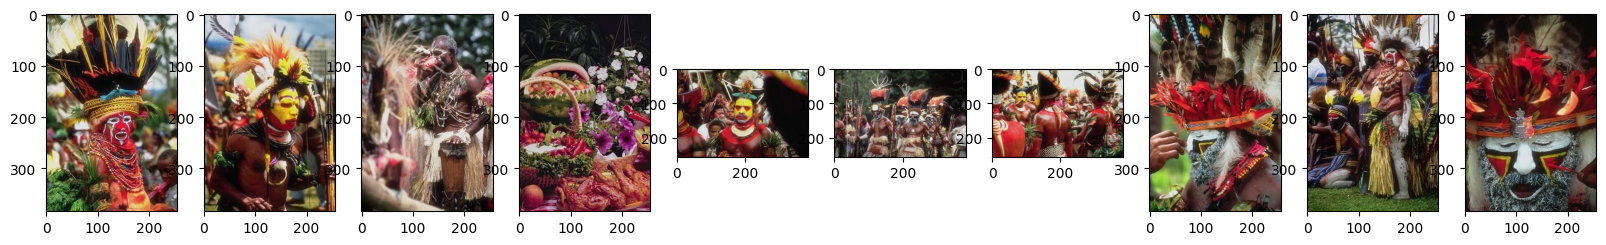

In [44]:
filename = 'static/80.jpg' ## CAMBIAR NOMBRE IMG (o no)
plot_c(filename)


In [45]:
filename = 'static/302.jpg' ## CAMBIAR NOMBRE IMG (o no)
plot_c(filename)

1/1 [==============================] - 0s 371ms/step


In [41]:
filename = 'static/123.jpg' ## CAMBIAR NOMBRE IMG (o no)
plot_c(filename)

1/1 [==============================] - 0s 342ms/step


1/1 [==============================] - 1s 522ms/step


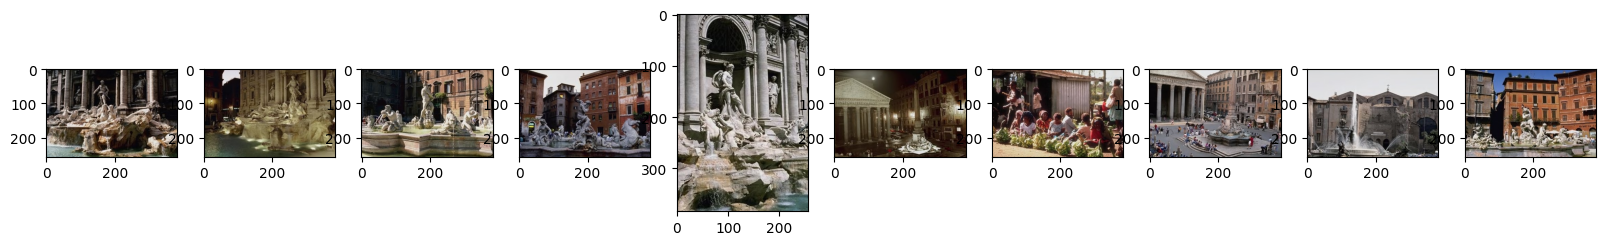

In [28]:
filename = 'static/269.jpg' ## CAMBIAR NOMBRE IMG (o no)
plot_c(filename)

1/1 [==============================] - 0s 340ms/step


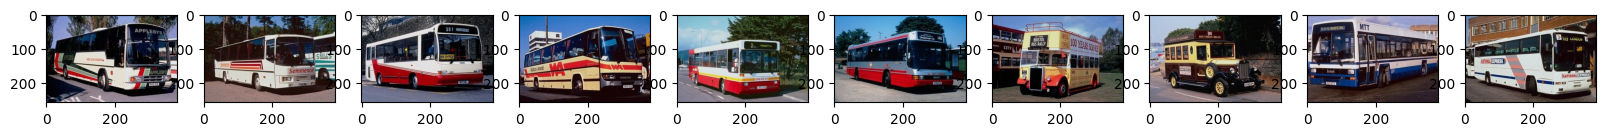

In [29]:
filename = 'static/351.jpg' ## CAMBIAR NOMBRE IMG (o no)
plot_c(filename)

1/1 [==============================] - 0s 288ms/step


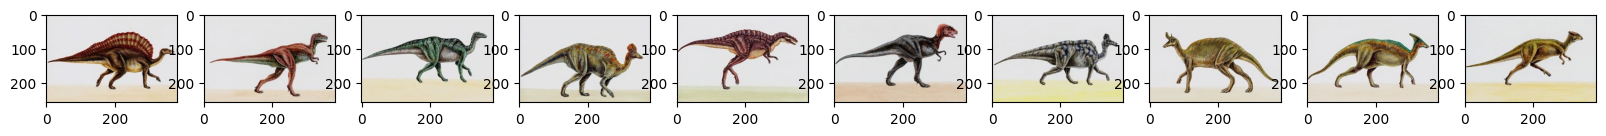

In [30]:
filename = 'static/475.jpg' ## CAMBIAR NOMBRE IMG (o no)
plot_c(filename)

1/1 [==============================] - 0s 394ms/step


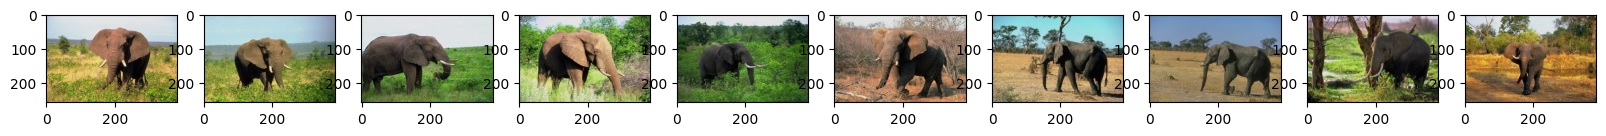

In [31]:
filename = 'static/508.jpg' ## CAMBIAR NOMBRE IMG (o no)
plot_c(filename)

1/1 [==============================] - 0s 293ms/step


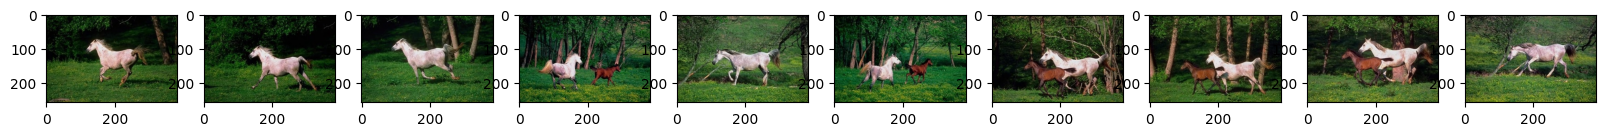

In [32]:
filename = 'static/784.jpg' ## CAMBIAR NOMBRE IMG (o no)
plot_c(filename)

1/1 [==============================] - 0s 290ms/step


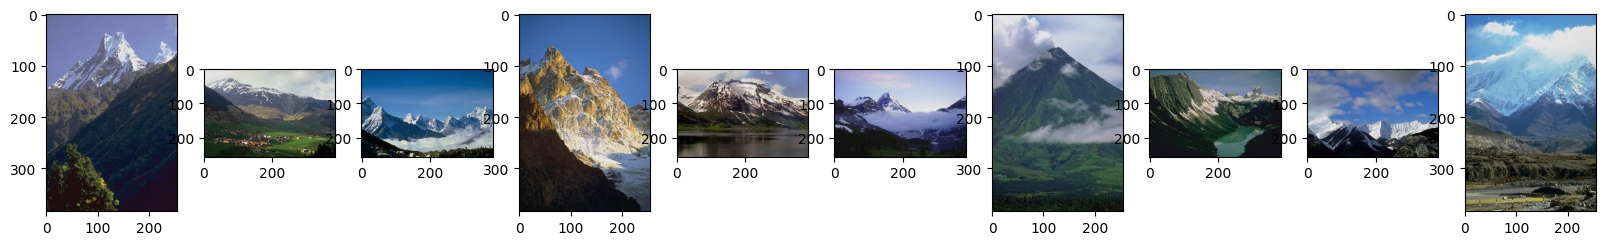

In [33]:
filename = 'static/842.jpg' ## CAMBIAR NOMBRE IMG (o no)
plot_c(filename)

1/1 [==============================] - 0s 398ms/step


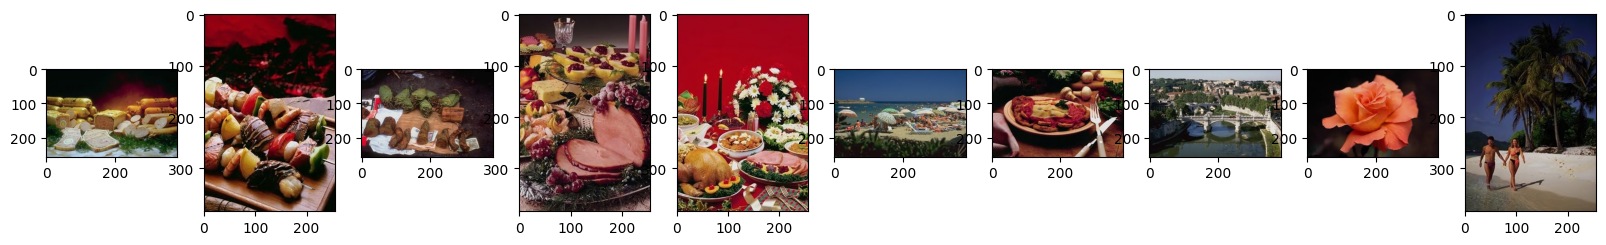

In [34]:
filename = 'static/902.jpg' ## CAMBIAR NOMBRE IMG (o no)
plot_c(filename)